# Group 41 STAT-301 Project Proposal: Predicting Metacritic Score of Steam Games
### Introduction

Steam is the largest digital distribution platform for computer games. The platform can be seen as a digital community market. It allows its users to purchase games, adding them to a virtual library from which they may be downloaded and installed an unlimited number of times. Metacritic scores rate the overall performance of video games ranging from 0-100, with higher scores indicating more positive reviews, and lower scores indicating less favorable reviews from critics. These scores are helpful since there are thousands of different types of video games published on Steam and consumers may find it difficult to make decisions. There is also research showing that Metacritic scores at least partially explain player experience (Johnson et al., 2014). Therefore, a game's Metacritic score may help consumers make a decision about their game purchasing. And since Metacritic scores have a strong correlation with game sales (Greenwood-Ericksen et al., 2013), understanding and predicting them is important for sellers as well.

 In our project, we will predict the Metacritic score of Steam games (the response variable) released after the year 1970, based on input variables such as the price, the number of recommendations, and release date of a game. The project will be focused on both prediction and inference. Although our main goal is to predict the game's Metacritic Score, it will be also interesting to find out the different relationships between a game's Metacritic score and its input variables (i.e. which variables explain the variation in Metacritic score the best). 
 
 
 The dataset we used is collected and released under the Steam API (Steam Games, 2022). It has the following 19 variables:
- 'ResponseName'
- 'ReleaseDate'
- 'Metacritic'
- 'RecommendationCount'
- 'IsFree'
- 'GenreIsNonGame'
- 'GenreIsIndie'
- 'GenreIsAction'
- 'GenreIsAdventure'
- 'GenreIsCasual'
- 'GenreIsStrategy'
- 'GenreIsRPG'
- 'GenreIsSimulation'
- 'GenreIsEarlyAccess'
- 'GenreIsFreeToPlay'
- 'GenreIsSports'
- 'GenreIsRacing'
- 'GenreIsMassivelyMultiplayer'
- 'PriceInitial'

The variable `ResponseName` will not be used as it is a unique value representing the name of a game. The continuous input variables in this dataset are `ReleaseDate` (representing the number of days passed since January 1st, 1970), `PriceInitial` (the price of a video game), and `RecommendationCount` (the number of recommendations of a game on Steam). The other variables are logicals (i.e. TRUE  or FALSE) that say whether or not a game fits into a certain genre or category. 


### Preliminary Results
In this section, we will demonstrate that we can read the data from the web and wrangle it into a tidy format. We will also address our primary question with plots and tables.
#### Reading the Data

In [7]:
# load libraries + set options

options(jupyter.plot_mimetypes="image/png")

library(repr)
library(digest)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(tidyverse)
library(broom)
library(glmnet)
library(repr)
library(car)
library(GGally)



options(jupyter.plot_mimetypes = "image/png")

ERROR: Error in library(gridExtra): there is no package called ‘gridExtra’


In [4]:
#read_csv on a url, which responds with the data
steam_games <- read_csv('https://raw.githubusercontent.com/DanielZCode/STAT-301-Project/main/games-features-edit.csv')
                                                                                           
head(steam_games) # preview of the data 
nrow(steam_games) # 12624 data points (games)
colnames(steam_games) #variable names, number of variables == 19
#length(colnames(steam_games)) #prints out number of variables



ERROR: Error in read_csv("https://raw.githubusercontent.com/DanielZCode/STAT-301-Project/main/games-features-edit.csv"): could not find function "read_csv"


#### Data Wrangling 
In order to correctly use the `ReleaseDate` variable, we will need to convert it from its current character-based format to a numerical value. Although it would be convenient to convert this variable year that the game was released, that would not be a true continuous variable since years are mostly discrete (especially in the case of Steam games, where the data available is fairly recent). Hence, we will need to convert `ReleaseDate` to a continuous variable representing the number of days passed since January 1st, 1970. This is a common representation of time in computers. 

In addition, we will filter the data for missing values, and also check that a game's `Metacritic` score is not 0, because that indicates a lack of reviews and an unplayed game. By safely removing those outliers and missing values, we can generate the more accurate model. We will also filter only for games that were released after 1970.


In [182]:
sum(is.na(steam_games)) # dataset has 86 missing data points
sum(is.na(steam_games$ReleaseDate)) #all missing data is inside the ReleaseDate 

set.seed(3012)

#convert dates to days since 1970 (default internal representation) 
steam_games$ReleaseDate <- steam_games$ReleaseDate %>% as.Date(format="%b%d%Y") %>%  as.numeric() 


steam_games <- steam_games %>% drop_na() %>% filter(Metacritic > 0, ReleaseDate > 0) # filter for more than 0 days passed since 1970, metacritic score > 0

steam_games <- steam_games %>% mutate_if(is.logical, as_factor) #convert logicals to factors



length(unique(steam_games$GenreIsNonGame)) # == 1, hence only one value for this variable is present, no variation

steam_games <- steam_games %>% select(-GenreIsNonGame,-GenreIsFreeToPlay) # remove variables

head(steam_games)
nrow(steam_games) ## number of steam games, filtered


[1] 86

[1] 86

[1] 1

ResponseName,ReleaseDate,Metacritic,RecommendationCount,IsFree,GenreIsIndie,GenreIsAction,GenreIsAdventure,GenreIsCasual,GenreIsStrategy,GenreIsRPG,GenreIsSimulation,GenreIsEarlyAccess,GenreIsSports,GenreIsRacing,GenreIsMassivelyMultiplayer,PriceInitial
<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
Counter-Strike,11262,88,68991,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,9.99
Day of Defeat,12173,79,2319,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,4.99
Half-Life,10538,96,12486,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,9.99
Counter-Strike: Condition Zero,12478,65,7067,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,9.99
Counter-Strike: Condition Zero,12478,65,7067,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,9.99
Half-Life: Blue Shift,11474,71,2219,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,4.99


[1] 2241

After wrangling the data in this way, we are left with 2241 observations, down from the original 12624 observations.

In this dataset, it turns out that the `GenreIsNonGame` variable is always false. Because this variable has no variation, it will be removed.

The binary variable `IsFree` is equivalent to the the binary variable `GenreIsFreeToPlay`. Therefore, the GenreIsFreeToPlay will be removed.

#### Exploratory Analysis
In this section we will explore some estimates variables. In addition we will plot visualizations of our reponse variable, `Metacritic`, and its relation to other variables.

First, let us see the distribution of `Metacritic` scores.

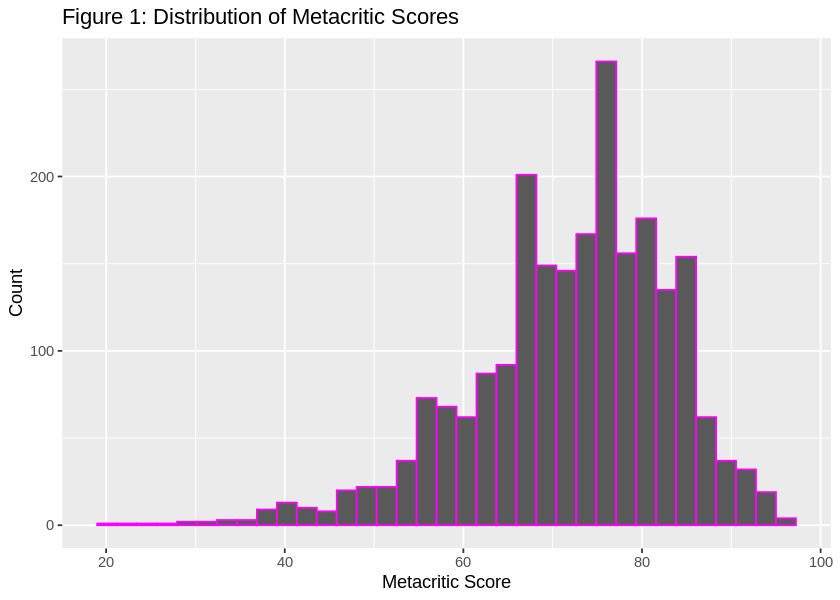

In [183]:
options(repr.plot.width = 7, repr.plot.height = 5)

steam_games_metacritic_dist <- steam_games %>% ggplot() +
    geom_histogram(aes(x = Metacritic), bins = 35, color = '#FF00FF') +
    ggtitle('Figure 1: Distribution of Metacritic Scores') +
    labs(x = 'Metacritic Score', y = 'Count')

steam_games_metacritic_dist

    

Next, let us plot the relationship of Metacritic Score with the other continous variables.

`geom_smooth()` using formula 'y ~ x'



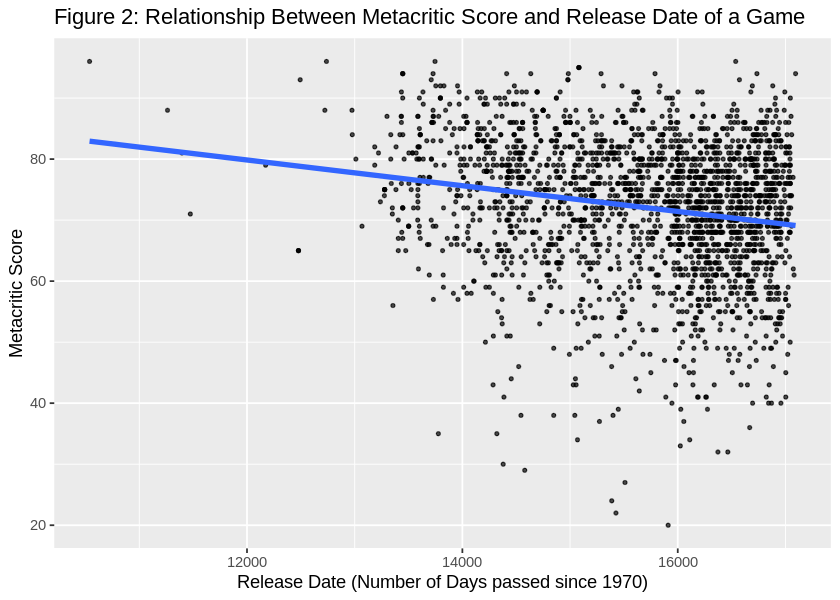

In [184]:
steam_games_metacritic_releasedate_plot <- steam_games %>% ggplot() +
    geom_point(aes(x = ReleaseDate, y = Metacritic), size = 0.8, alpha = 0.7) +
    geom_smooth(aes(x = ReleaseDate, y = Metacritic), method = lm, se = FALSE, size = 1.5) +
    ggtitle('Figure 2: Relationship Between Metacritic Score and Release Date of a Game') +
    labs(y = 'Metacritic Score', x = 'Release Date (Number of Days passed since 1970)')
steam_games_metacritic_releasedate_plot

`geom_smooth()` using formula 'y ~ x'



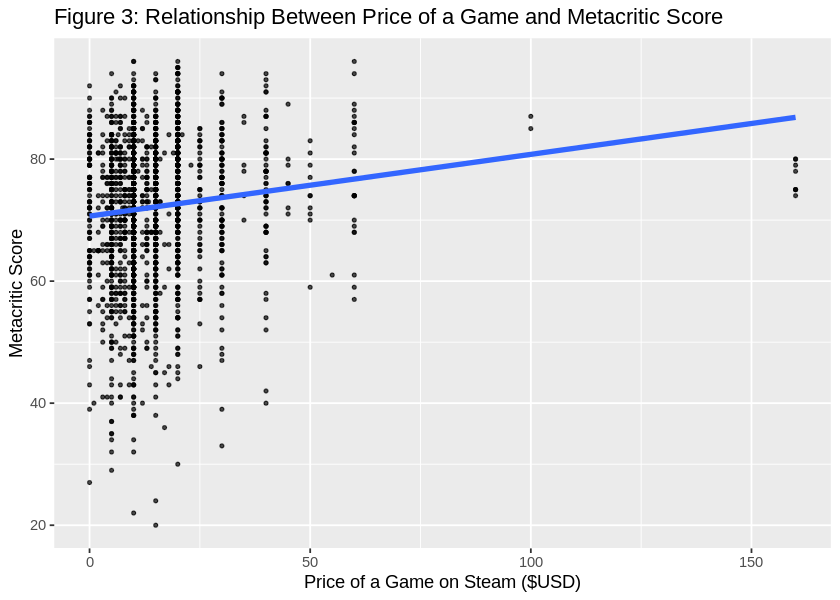

In [185]:
steam_games_metacritic_price_plot <- steam_games %>% ggplot() +
    geom_point(aes(x = PriceInitial, y = Metacritic),  size = 0.8, alpha = 0.7) +
    geom_smooth(aes(x = PriceInitial, y = Metacritic), method = lm, se = FALSE, size = 1.5) +
    ggtitle('Figure 3: Relationship Between Price of a Game and Metacritic Score') +
    labs(y = 'Metacritic Score', x = 'Price of a Game on Steam ($USD)')
steam_games_metacritic_price_plot

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 184 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 184 rows containing missing values (geom_point).”


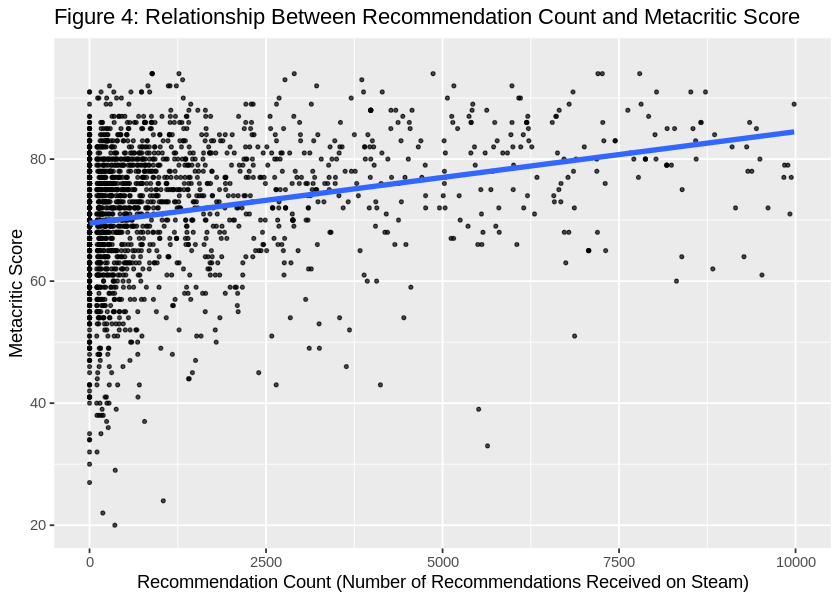

In [186]:
steam_games_metacritic_recommendation_plot <- steam_games %>% ggplot() +
    geom_point(aes(x = RecommendationCount, y = Metacritic),  size = 0.8, alpha = 0.7) +
    geom_smooth(aes(x = RecommendationCount, y = Metacritic), method = lm, se = FALSE, size = 1.5) +
    scale_x_continuous(limits = c(0, 10000)) +
    ggtitle('Figure 4: Relationship Between Recommendation Count and Metacritic Score') +
    labs(y = 'Metacritic Score', x = 'Recommendation Count (Number of Recommendations Received on Steam)')
steam_games_metacritic_recommendation_plot

**Note:** About 180 data points were removed in **Figure 4** for increased clarity.


#### Estimates
Below we will compute some estimates of the data.


In [187]:
steam_games_summarized <- steam_games %>% summarize(Metacritic_mean = mean(Metacritic),
                                                    Metacritic_sd = sd(Metacritic),
                                                    ReleaseDate_mean = mean(ReleaseDate), 
                                                    ReleaseDate_mean_Date = format(as.Date(ReleaseDate_mean, origin ='1970-01-01'), '%B %d, %Y'),
                                                    RecommendationCount_mean = mean(RecommendationCount),
                                                    PriceInitial_mean = mean(PriceInitial))
steam_games_summarized

Metacritic_mean,Metacritic_sd,ReleaseDate_mean,ReleaseDate_mean_Date,RecommendationCount_mean,PriceInitial_mean
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
72.16198,11.17587,15648.85,"November 04, 2012",4637.252,14.8627


**Figure 5. Averages of different variables**

As we can see, the average Metacritic score of a Steam game is approximately **72**, and the average release date was in **November, 2012**. In addition, Steam games have received around **4600** recommendations on average, and have a mean price of approximately **$15**.

### Methods and Results

First, we should split the data into a training and testing set, where the training set is 60% of the entire data. This is done in the cell below. 

In [188]:
set.seed(3012)
steam_games$ID = 1:nrow(steam_games)
training_Steam <- sample_n(steam_games, size = nrow(steam_games) * 0.60,
  replace = FALSE
)

testing_Steam <- anti_join(steam_games,
  training_Steam,
  by = "ID"
)

# Remove Game ID
training_Steam <- training_Steam %>% select(-"ID")
testing_Steam <- testing_Steam %>% select(-"ID")


#### Preliminary Model
Now, let's compute an additive linear regression model using all of the variables. This will help us understand which variables are statistically significant, and which variables are not.

In [210]:
steam_games_mlr_add <- lm(Metacritic ~ ., data = training_Steam %>% select(-ResponseName)) #use training steam as the data, but omit ResponseName

steam_games_mlr_add_tidy <- tidy(steam_games_mlr_add, conf.level = 0.9, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2) #show estimates and intervals
steam_games_mlr_add_tidy

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),112.61,5.00,22.54,0.00,104.39,120.84
ReleaseDate,0.00,0.00,-7.82,0.00,0.00,0.00
RecommendationCount,0.00,0.00,3.44,0.00,0.00,0.00
IsFreeTRUE,-1.85,1.78,-1.04,0.30,-4.77,1.08
GenreIsIndieTRUE,0.31,0.68,0.45,0.65,-0.82,1.43
GenreIsActionTRUE,-2.19,0.66,-3.29,0.00,-3.28,-1.09
GenreIsAdventureTRUE,-0.50,0.72,-0.69,0.49,-1.69,0.69
GenreIsCasualTRUE,-0.96,1.02,-0.95,0.34,-2.64,0.71
GenreIsStrategyTRUE,-1.09,0.79,-1.37,0.17,-2.39,0.22


value 
9.650474e-22

**Figure 6. Estimated Coefficients of an Additive Multiple Linear Regression Model**

Below we will compute the p-value of this model to ensure that it is better than an intercept-only model. 

In [211]:
glance(steam_games_mlr_add)$p.value

value 
9.650474e-22

The full model above may not be the best, and given the amount of variables used it may be overfitting. Besides, the LR assumes a linear relationship and might not be the best way to find the predictors for the response variable. 
In our situation of making prediction of the Metacritic score, we will use LASSO selection, with this penalized method to smothly select the variables for the predictive model.

We will also to check that the assumptions of our models hold, namely that multicollinearity is minimal. We do this in the cell below by computing the variance inflation factor. 

In [214]:
lasso_variables_vif <- 
   vif(lm(Metacritic ~ReleaseDate+RecommendationCount+IsFree+GenreIsIndie+GenreIsAction+GenreIsAdventure+GenreIsCasual+GenreIsStrategy+GenreIsRPG+GenreIsSimulation+GenreIsEarlyAccess+GenreIsSports+
GenreIsRacing+GenreIsMassivelyMultiplayer+PriceInitial,data=training_Steam))

lasso_variables_vif

ReleaseDate         RecommendationCount 
                   1.386603                    1.009189 
                     IsFree                GenreIsIndie 
                   1.353352                    1.326398 
              GenreIsAction            GenreIsAdventure 
                   1.269169                    1.345620 
              GenreIsCasual             GenreIsStrategy 
                   1.094795                    1.418599 
                 GenreIsRPG           GenreIsSimulation 
                   1.088802                    1.144965 
         GenreIsEarlyAccess               GenreIsSports 
                   1.003225                    1.225913 
              GenreIsRacing GenreIsMassivelyMultiplayer 
                   1.240268                    1.370189 
               PriceInitial 
                   1.138187

All of the input variables have a variance inflation factor (VIF) of between 1 - 1.5. Because the VIF is not very high, we are reasonably confident that multicollinearity will not be a problem.

To continue with LASSO selection, will build a matrix and vector with the data so it can be properly used by the `glmnet` function.

In [191]:
# head(training_Steam)
# nrow(training_Steam)
#head(testing_Steam)
# nrow(testing_Steam)
Steam_X_test <- testing_Steam %>% select(-"Metacritic",-"ResponseName")  %>% data.matrix()
Steam_Y_test <- unlist(testing_Steam[, "Metacritic"])%>%as.numeric()
# Build matrix and vector required by `glmnet`

Steam_X_train <- model.matrix(Metacritic ~ . -ResponseName,
  data = training_Steam)[, -1] #remove index

Steam_Y_train <- unlist(training_Steam[, "Metacritic"])%>%as.numeric()

head(Steam_X_train) 
head(Steam_Y_train)


,ReleaseDate,RecommendationCount,IsFreeTRUE,GenreIsIndieTRUE,GenreIsActionTRUE,GenreIsAdventureTRUE,GenreIsCasualTRUE,GenreIsStrategyTRUE,GenreIsRPGTRUE,GenreIsSimulationTRUE,GenreIsEarlyAccessTRUE,GenreIsSportsTRUE,GenreIsRacingTRUE,GenreIsMassivelyMultiplayerTRUE,PriceInitial
1,13950,450,0,0,1,1,0,0,0,0,0,0,0,0,4.99
2,14838,2723,0,0,1,0,0,0,0,0,0,0,0,0,9.99
3,15244,2186,0,0,1,0,0,0,0,0,0,0,1,0,19.99
4,16301,16575,0,1,0,0,0,0,0,1,0,0,0,0,4.99
5,15047,1337,0,1,0,0,0,1,0,0,0,0,0,0,9.99
6,15015,339,0,0,0,0,0,1,1,0,0,0,0,0,9.99


[1] 69 66 80 78 75 65

We will now select the value of  𝜆  that provides the smallest  MSE test  using cross-validation. Finally, we will fit the model using this lambda value.

[1] 2.371

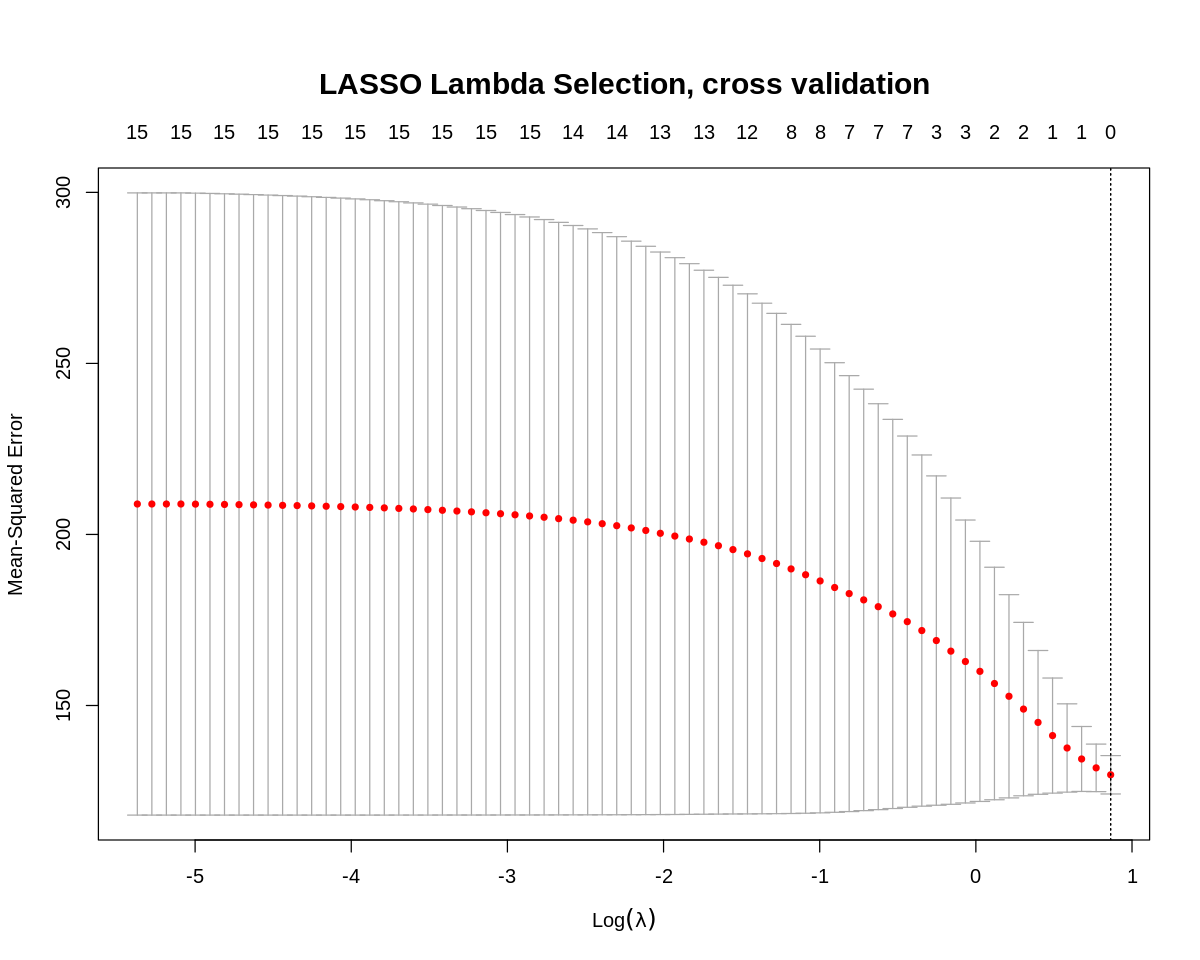

In [203]:
Steam_cv_lambda_LASSO <- cv.glmnet(
  x = Steam_X_train, y = Steam_Y_train,
  alpha = 1)


Steam_lambda_min_MSE <- round(Steam_cv_lambda_LASSO$lambda.min, 4)
Steam_lambda_min_MSE

options(repr.plot.height = 8, repr.plot.width = 10)
par(mar = c(5, 4.1, 7, 2.1))
plot(Steam_cv_lambda_LASSO)
title(main = 'LASSO Lambda Selection, cross validation', cex.main = 1.5)

In [218]:
#Fit Lasso regression with selected lamda
LASSO_min_add <- glmnet(
  x = Steam_X_train, y = Steam_Y_train,
  alpha = 1,
  lambda = Steam_lambda_min_MSE
)

coef(LASSO_min_add)


16 x 1 sparse Matrix of class "dgCMatrix"
                                      s0
(Intercept)                     71.94866
ReleaseDate                      0.00000
RecommendationCount              .      
IsFreeTRUE                       .      
GenreIsIndieTRUE                 .      
GenreIsActionTRUE                .      
GenreIsAdventureTRUE             .      
GenreIsCasualTRUE                .      
GenreIsStrategyTRUE              .      
GenreIsRPGTRUE                   .      
GenreIsSimulationTRUE            .      
GenreIsEarlyAccessTRUE           .      
GenreIsSportsTRUE                .      
GenreIsRacingTRUE                .      
GenreIsMassivelyMultiplayerTRUE  .      
PriceInitial                     .      

Unfortunately, it looks like LASSO selected against using all of the variables, and chose to use only the intercept. This is somewhat of an unusual result given that our full linear regression model was statistically better than the intercept-only model. However, it appears that although the p-value was small, these variables were still not all that relevant in predicting the `Metacritic` score (perhaps because of a low effect-size). 

Now, we will use the trained model to predict the Metacritic score in the test set. For comparison, we will also compute the rmse of our full additive linear regression model. 

In [194]:
Steam_test_pred_LASSO <- predict(LASSO_min_add,
  newx =Steam_X_test)

rmse_stats <- tibble(
    Model = "LASSO Regression with minimum MSE",
    R_MSE = rmse(
      preds = Steam_test_pred_LASSO,
      actuals = testing_Steam$Metacritic
    )
  )

testing_Steam_lm_format <- testing_Steam %>% select(-Metacritic, -ResponseName)

Steam_test_pred_full_mlr <- predict(steam_games_mlr_add,
  newdata = testing_Steam_lm_format)


rbind(rmse_stats,
      tibble(Model = "Full Additive Linear Regression (No penalization or selection)",
            R_MSE = rmse(
                preds = Steam_test_pred_full_mlr,
                actuals = testing_Steam$Metacritic
            )
            )
      )

Model,R_MSE
<chr>,<dbl>
LASSO Regression with minimum MSE,10.98609
Full Additive Linear Regression (No penalization or selection),10.65185


**Figure 7. RMSE of LASSO selected model and Full Additive Linear Regression**

RMSE measures is generally a measure of error between our predicted values and the actual values. A lower RMSE is better. In this case, these results imply that the square root of the average of the square residuals is around 11 for both of our models. In this case, the full linear regression model performed slightly better, but these results may be down to chance and the particular split of the data.  


### Methods

This report uses a dataset with huge sample of 12624 games and 19 variables. Once filtered to remove observations with missing values, the sample size became more reasonable, at around 2000. 

Wrangling was done to make variables easier to use in our model. The `ReleaseDate` variable was converted from a character format to a continuous variable. All of the logical variables representing a game's genre or category were converted to a factor so that our models could use them. 

The report uses scatterplots and tables to visualize and summarize the data and the relationships between variables. It also fits an additive multiple linear regression model using all of the variables in the dataset. However, more must be done in the final report. In particular, we will need to employ model selection techniques to answer our inferential questions and figure out which variables are relevant. To answer our predictive questions we will also need to evaluate our models using metrics such the **MSE** (Mean Squared Error). 


If we are able to successfully create a predictive model for Metacritic scores, consumers could use this model to easily make a decision about their gaming purchase based on some input variables. Additionally, statistical analysis of this dataset will allow us to understand the relationship between Metacritic scores and other properties of a game. 



### References


Greenwood-Ericksen, A., Poorman, S. R., &amp; Papp, R. (2013). On the validity of Metacritic in assessing game value. *Eludamos: Journal for Computer Game Culture, 7*(1), 101–127. https://doi.org/10.7557/23.6150 

Johnson, D., Watling, C., Gardner, J., &amp; Nacke, L. E. (2014). The edge of glory: the relationship between metacritic scores and player experience. *Proceedings of the First ACM SIGCHI Annual Symposium on Computer-Human Interaction in Play*. https://doi.org/10.1145/2658537.2658694 

*Steam games*. Kaggle. (2022, October 21). Retrieved November 9, 2022, from https://www.kaggle.com/datasets/thedevastator/get-your-game-on-metacritic-recommendations-and 

